In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,count
import requests

spark= SparkSession \
       .builder \
       .appName("Datos Cientificos") \
       .getOrCreate()

spark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,738 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:13 https://r2u.stat.illinois.e

In [ ]:
import requests
import pandas as pd
from google.colab import data_table  # Para usar DataTable en Colab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

# Cargar primer dataset
# Descargar el archivo CSV desde la URL
path = kagglehub.dataset_download("ikynahidwin/depression-student-dataset")
df_depression = spark.read.csv(path, header=True, inferSchema=True)

#Generate data so that it is more than 1gb
# Pandas can not handle it.
desired_size = 20000000  # 10 millones
current_size = df_depression.count()
sampling_ratio = desired_size / current_size
depression = df_depression.sample(withReplacement=True, fraction=sampling_ratio, seed=42)

# Convertir el DataFrame de PySpark a Pandas para visualizarlo de forma más amigable
#df_depression_pandas = df_depression.toPandas()

#Cargar segundo dataset
path = kagglehub.dataset_download("steve1215rogg/student-lifestyle-dataset")
lifestyle = spark.read.csv(path, header=True, inferSchema=True)

sampling_ratio = 10000000 / lifestyle.count()
lifestyle = lifestyle.sample(withReplacement=True, fraction=sampling_ratio, seed=42)


100%|██████████| 4.25k/4.25k [00:00<00:00, 1.09MB/s]

Extracting files...


100%|██████████| 21.6k/21.6k [00:00<00:00, 12.9MB/s]

Extracting files...


# EDA
*Data Integrity*
- Check if the data is ready.
- Data set was already clean

In [ ]:
depression.printSchema()
depression.count()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Study Hours: integer (nullable = true)
 |-- Financial Stress: integer (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: string (nullable = true)



20007137

In [ ]:
lifestyle.printSchema()
lifestyle.count()

root
 |-- Student_ID: integer (nullable = true)
 |-- Study_Hours_Per_Day: double (nullable = true)
 |-- Extracurricular_Hours_Per_Day: double (nullable = true)
 |-- Sleep_Hours_Per_Day: double (nullable = true)
 |-- Social_Hours_Per_Day: double (nullable = true)
 |-- Physical_Activity_Hours_Per_Day: double (nullable = true)
 |-- GPA: double (nullable = true)
 |-- Stress_Level: string (nullable = true)



10001415

In [ ]:
depression.show(10)

+------+---+-----------------+------------------+--------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|Gender|Age|Academic Pressure|Study Satisfaction|Sleep Duration|Dietary Habits|Have you ever had suicidal thoughts ?|Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+------+---+-----------------+------------------+--------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|  Male| 28|              2.0|               4.0|     7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              2.0|               4.0|     7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              2.0|               

In [ ]:
depression.dtypes

[('Gender', 'string'),
 ('Age', 'int'),
 ('Academic Pressure', 'double'),
 ('Study Satisfaction', 'double'),
 ('Sleep Duration', 'string'),
 ('Dietary Habits', 'string'),
 ('Have you ever had suicidal thoughts ?', 'string'),
 ('Study Hours', 'int'),
 ('Financial Stress', 'int'),
 ('Family History of Mental Illness', 'string'),
 ('Depression', 'string')]

In [ ]:
#depression.describe().show()

## Visualize the data to better understand
- Check for inbalances
- Correlations

<Axes: xlabel='Depression'>

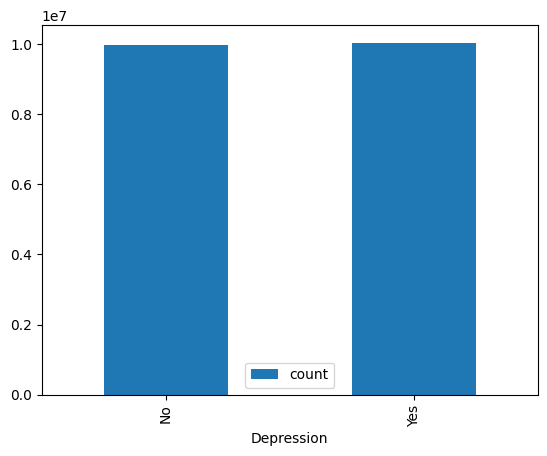

In [ ]:
df = depression.groupBy("Depression").count().toPandas()
df.plot(kind='bar', x='Depression', y='count')

<Axes: xlabel='Gender', ylabel='count'>

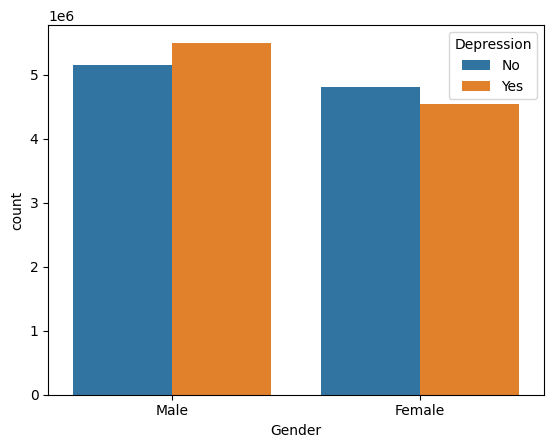

In [ ]:
df = depression.groupBy(["Gender",'Depression']).count().toPandas()
sns.barplot(data=df, x='Gender', y='count', hue='Depression')

<Axes: xlabel='Age', ylabel='count'>

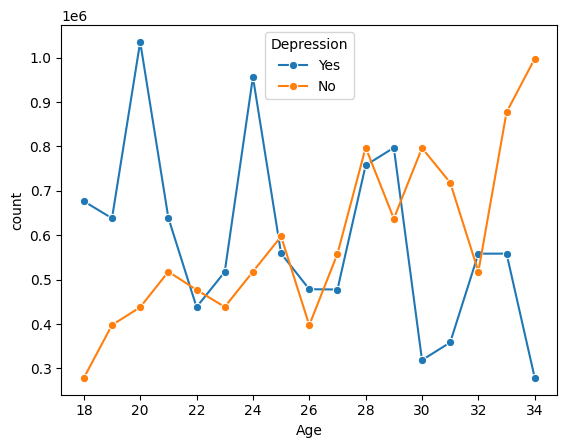

In [ ]:
df = depression.groupBy(["Depression",'Age']).count().toPandas()
sns.lineplot(df, x='Age', y='count',hue='Depression', marker='o')

<Axes: xlabel='Academic Pressure', ylabel='count'>

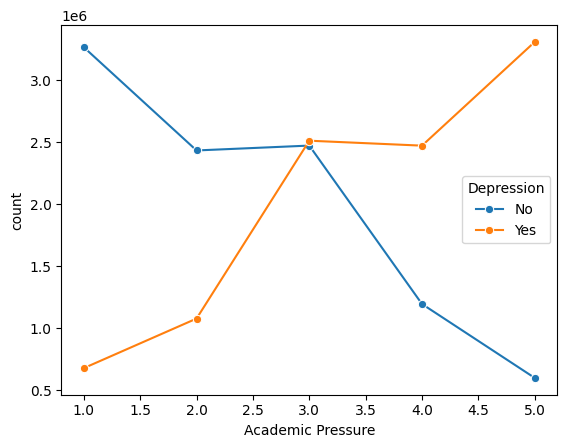

In [ ]:
df = depression.groupBy(["Depression",'Academic Pressure']).count().toPandas()
sns.lineplot(data=df, x="Academic Pressure", y="count", hue="Depression", marker="o")

<Axes: xlabel='Depression', ylabel='count'>

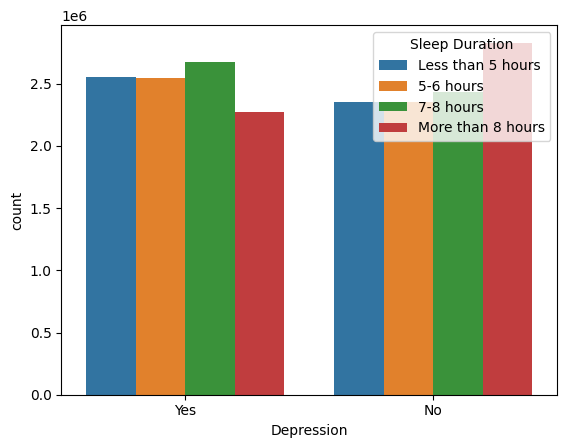

In [ ]:
df = depression.groupBy(["Depression",'Sleep Duration']).count().toPandas()
#df.head()
sns.barplot(data=df, x="Depression", y='count',hue="Sleep Duration", hue_order=['Less than 5 hours','5-6 hours','7-8 hours','More than 8 hours'])

<Axes: xlabel='Depression', ylabel='count'>

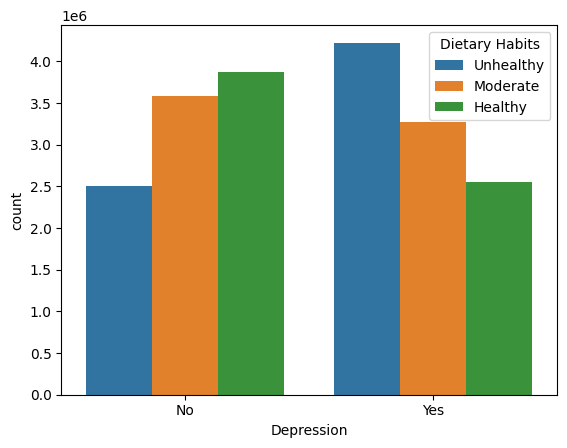

In [ ]:
df = depression.groupBy(["Depression",'Dietary Habits']).count().toPandas()
sns.barplot(data=df, x="Depression", y='count',hue="Dietary Habits", hue_order=['Unhealthy','Moderate','Healthy'])

<Axes: xlabel='Depression', ylabel='count'>

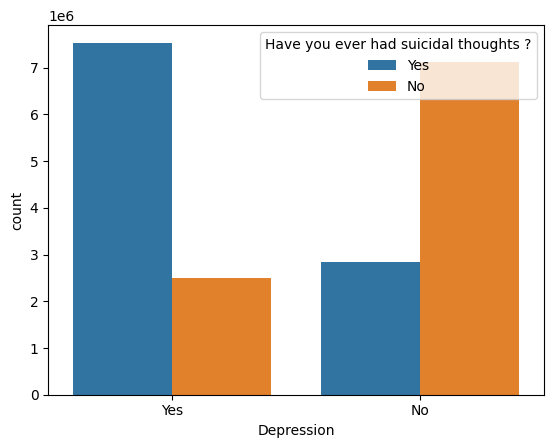

In [ ]:
df = depression.groupBy(["Depression",'Have you ever had suicidal thoughts ?']).count().toPandas()
sns.barplot(data=df, x="Depression", y='count',hue="Have you ever had suicidal thoughts ?")

<Axes: xlabel='Depression', ylabel='count'>

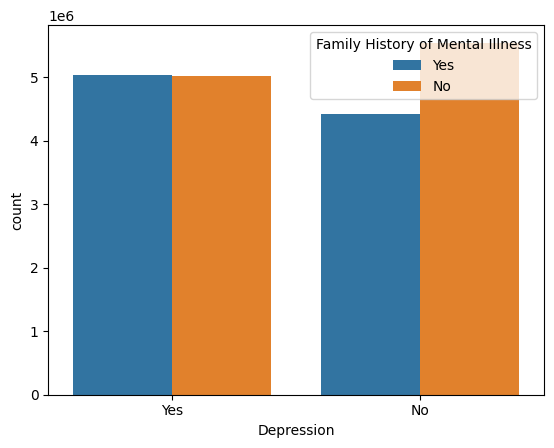

In [ ]:
df = depression.groupBy(["Depression",'Family History of Mental Illness']).count().toPandas()
sns.barplot(data=df, x="Depression", y='count',hue="Family History of Mental Illness")

<Axes: xlabel='Study Hours', ylabel='count'>

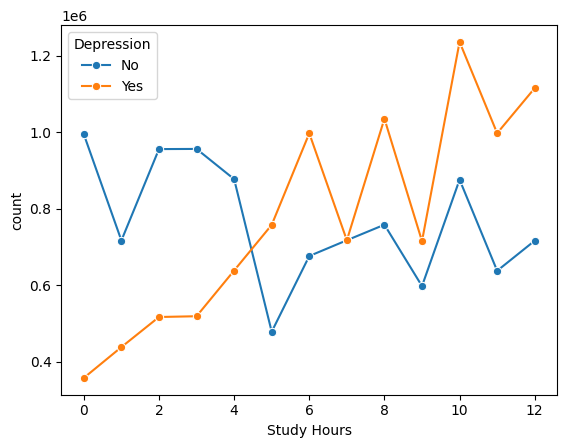

In [ ]:
df = depression.groupBy(["Depression",'Study Hours']).count().toPandas()
sns.lineplot(data=df, x="Study Hours", y="count", hue="Depression", marker="o")

<Axes: xlabel='Financial Stress', ylabel='count'>

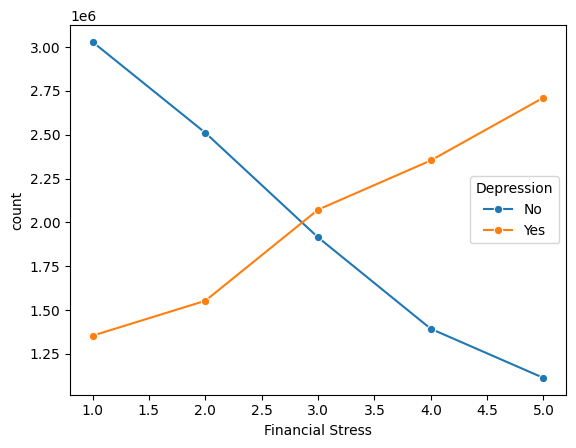

In [ ]:
df = depression.groupBy(["Depression",'Financial Stress']).count().toPandas()
sns.lineplot(data=df, x="Financial Stress", y="count", hue="Depression", marker="o")

## Crrelation Matrix

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
numerical_features = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
vectorized_data = assembler.transform(depression)
correlation_matrix = Correlation.corr(vectorized_data, "features").head()[0].toArray()

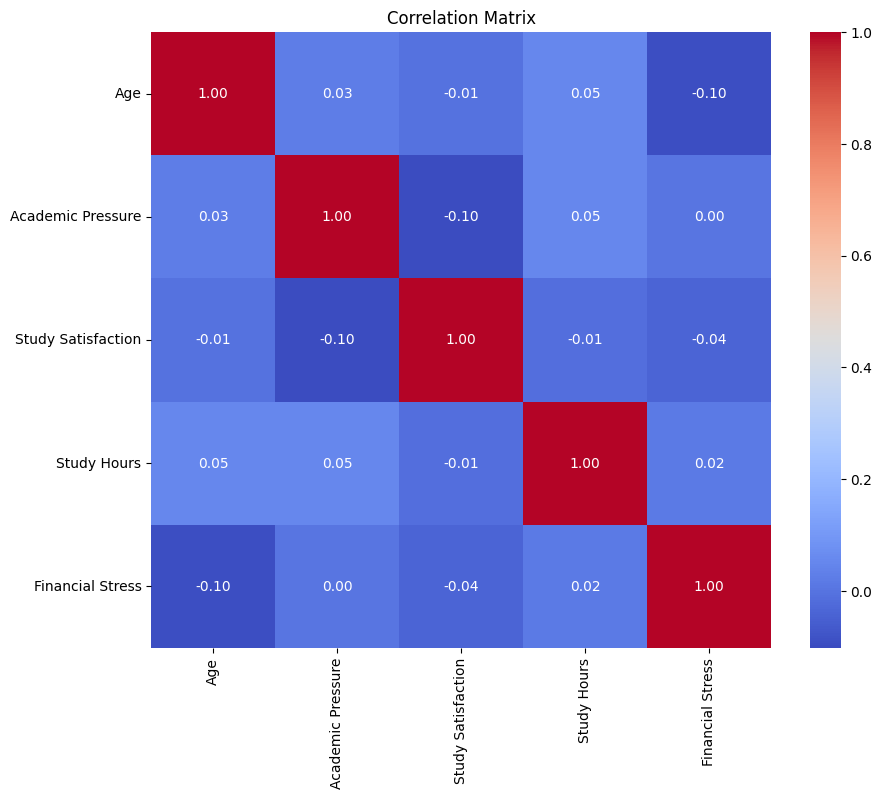

In [ ]:
corr_df = pd.DataFrame(correlation_matrix, columns=numerical_features, index=numerical_features)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
depression.dtypes

[('Gender', 'string'),
 ('Age', 'int'),
 ('Academic Pressure', 'double'),
 ('Study Satisfaction', 'double'),
 ('Sleep Duration', 'string'),
 ('Dietary Habits', 'string'),
 ('Have you ever had suicidal thoughts ?', 'string'),
 ('Study Hours', 'int'),
 ('Financial Stress', 'int'),
 ('Family History of Mental Illness', 'string'),
 ('Depression', 'string')]

In [ ]:
lifestyle.show(10)

+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+----+------------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day| GPA|Stress_Level|
+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+----+------------+
|         1|                6.9|                          3.8|                8.7|                 2.8|                            1.8|2.99|    Moderate|
|         1|                6.9|                          3.8|                8.7|                 2.8|                            1.8|2.99|    Moderate|
|         1|                6.9|                          3.8|                8.7|                 2.8|                            1.8|2.99|    Moderate|
|         1|                6.9|                          3.8|              

In [ ]:
lifestyle.dtypes

[('Student_ID', 'int'),
 ('Study_Hours_Per_Day', 'double'),
 ('Extracurricular_Hours_Per_Day', 'double'),
 ('Sleep_Hours_Per_Day', 'double'),
 ('Social_Hours_Per_Day', 'double'),
 ('Physical_Activity_Hours_Per_Day', 'double'),
 ('GPA', 'double'),
 ('Stress_Level', 'string')]

In [ ]:
lifestyle.describe().show()

+-------+------------------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------------+------------+
|summary|        Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day|               GPA|Stress_Level|
+-------+------------------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------------+------------+
|  count|          10001415|           10001415|                     10001415|           10001415|            10001415|                       10001415|          10001415|    10001415|
|   mean|1000.5568067118503| 7.4752990352211635|            1.990032960335842|   7.50209025420637|  2.7044079862761197|              4.328169763956297|3.1159857760059584|        NULL|
| stddev| 577.4398921663416|  1.423534645819052|           1.1553979279577553| 1

<Axes: xlabel='Stress_Level'>

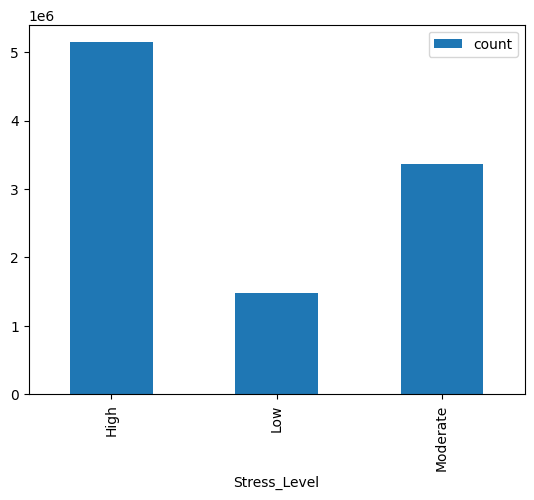

In [ ]:
df = lifestyle.groupBy("Stress_Level").count().toPandas()
df.plot(kind='bar', x='Stress_Level', y='count')

In [ ]:
class_counts = lifestyle.groupBy("Stress_Level").count()
min_class_size = class_counts.agg(F.min("count")).collect()[0][0]
undersampled_dfs = []

for cls in class_counts.collect():
    class_label = cls["Stress_Level"]
    undersampled_df = lifestyle.filter(F.col("Stress_Level") == class_label).sample(
        withReplacement=False, fraction=min_class_size / cls["count"], seed=42
    )
    undersampled_dfs.append(undersampled_df)

balanced_df = undersampled_dfs[0]
for undersampled_df in undersampled_dfs[1:]:
    balanced_df = balanced_df.union(undersampled_df)

balanced_df.groupBy("Stress_Level").count().show()

+------------+-------+
|Stress_Level|  count|
+------------+-------+
|        High|1489413|
|         Low|1487071|
|    Moderate|1488877|
+------------+-------+



In [ ]:
balanced_df.describe().show()

+-------+-----------------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+-------------------+------------+
|summary|       Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day|                GPA|Stress_Level|
+-------+-----------------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+-------------------+------------+
|  count|          4465361|            4465361|                      4465361|            4465361|             4465361|                        4465361|            4465361|     4465361|
|   mean|989.4824521466461|  6.944468274789705|           1.9919360831046946| 7.6868326883286295|  2.7526836911928987|              4.624079262574166|  3.034992807970262|        NULL|
| stddev|579.3540627498113| 1.4381918488025933|           1.1639985877824066| 1.

<Axes: xlabel='Study_Hours_Per_Day', ylabel='count'>

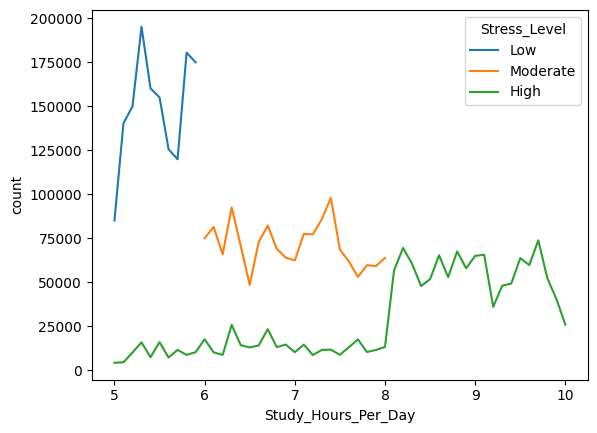

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'Study_Hours_Per_Day']).count().toPandas()
sns.lineplot(df,x='Study_Hours_Per_Day',y='count',hue='Stress_Level',hue_order=['Low','Moderate','High'])

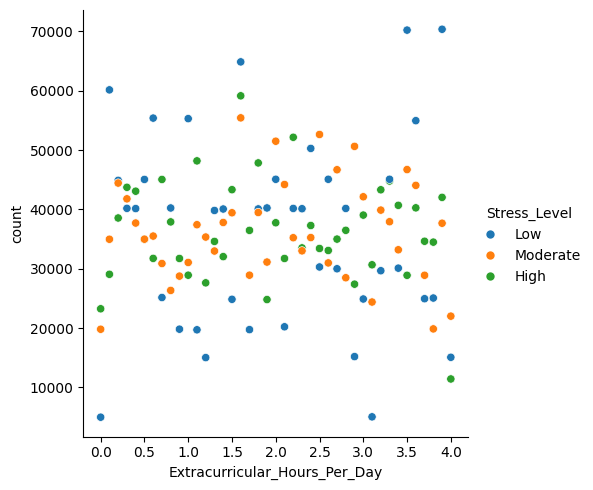

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'Extracurricular_Hours_Per_Day']).count().toPandas()
sns.relplot(data=df, x="Extracurricular_Hours_Per_Day", y="count", hue="Stress_Level",hue_order=['Low','Moderate','High'])

<Axes: xlabel='Sleep_Hours_Per_Day', ylabel='count'>

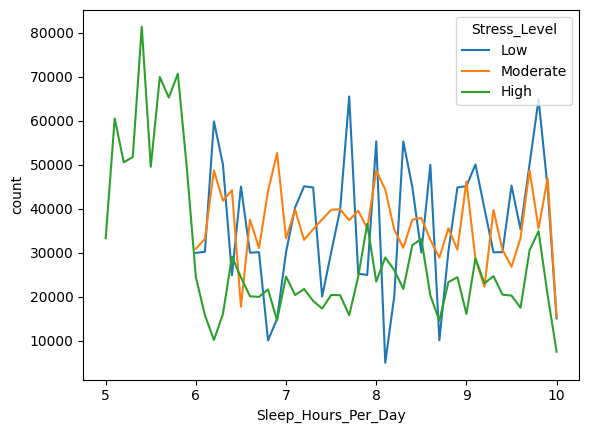

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'Sleep_Hours_Per_Day']).count().toPandas()
sns.lineplot(df,x='Sleep_Hours_Per_Day',y='count',hue='Stress_Level',hue_order=['Low','Moderate','High'])

<Axes: xlabel='Social_Hours_Per_Day', ylabel='count'>

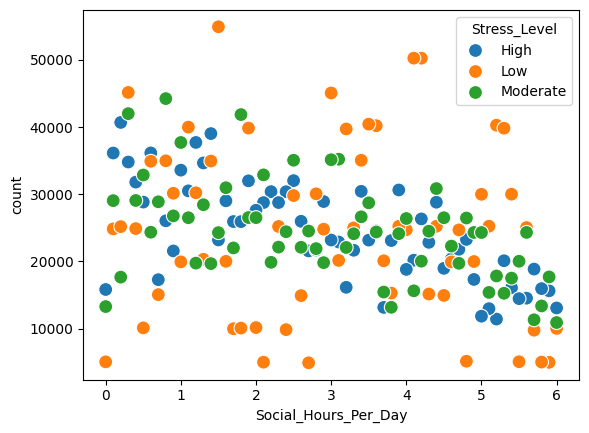

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'Social_Hours_Per_Day']).count().toPandas()
sns.scatterplot(x='Social_Hours_Per_Day', y='count', hue='Stress_Level', data=df, s=100)

<Axes: xlabel='Physical_Activity_Hours_Per_Day', ylabel='count'>

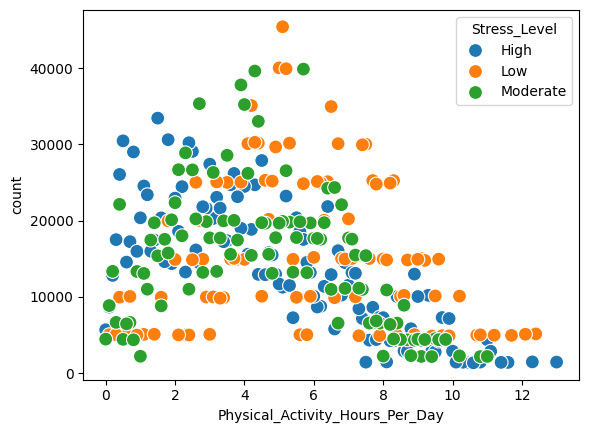

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'Physical_Activity_Hours_Per_Day']).count().toPandas()
sns.scatterplot(x='Physical_Activity_Hours_Per_Day', y='count', hue='Stress_Level', data=df, s=100)

<Axes: xlabel='GPA', ylabel='count'>

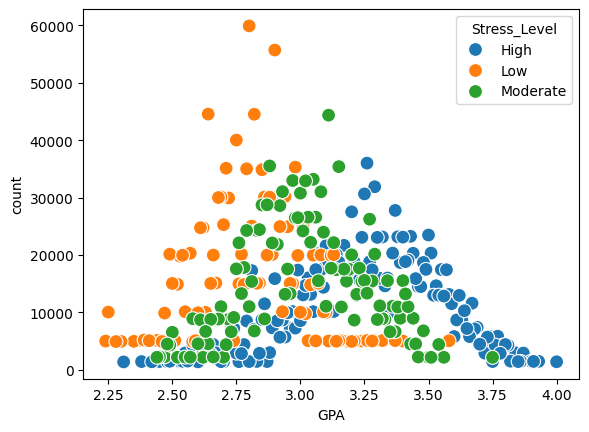

In [ ]:
df = balanced_df.groupBy(['Stress_Level', 'GPA']).count().toPandas()
sns.scatterplot(x='GPA', y='count', hue='Stress_Level', data=df, s=100)

In [ ]:
depression.show(10)

+------+---+-----------------+------------------+--------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|Gender|Age|Academic Pressure|Study Satisfaction|Sleep Duration|Dietary Habits|Have you ever had suicidal thoughts ?|Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+------+---+-----------------+------------------+--------------+--------------+-------------------------------------+-----------+----------------+--------------------------------+----------+
|  Male| 28|              2.0|               4.0|     7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              2.0|               4.0|     7-8 hours|      Moderate|                                  Yes|          9|               2|                             Yes|        No|
|  Male| 28|              2.0|               

<Axes: xlabel='Depression', ylabel='count'>

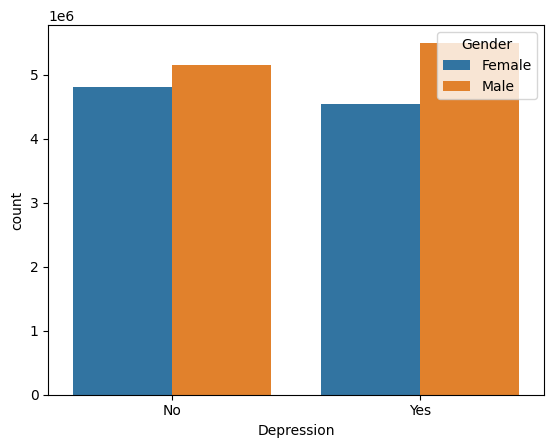

In [ ]:
df = depression.groupBy(["Depression",'Gender']).count().toPandas()
sns.barplot(data=df, x="Depression", y='count',hue="Gender")